In [ ]:
'''A continuación vamos a crear un programa que vaya orientando el RADAR y la cámara en base al YAW calculado
para ello, empezaremos haciéndolo con un FOV de 180 grados, y luego lo iremos reduciendo. Disponemos de un
ground truth de puntos de LIDAR 360 grados por lo que para simular el campo de visión que conseguiríamos con
el resto de sensores, vamos a ir eliminando puntos de LIDAR que no estén dentro del FOV e intentaremos hacer
un render de los puntos que sí están dentro del FOV. 

Emplearemos la scene-0916 para comparar como serían los resultados de si orientamos el RADAR y la cámara o no.
Además, lo vamos a hacer para los ángulos de YAW cálculados a partir de ambos métodos de estimación'''

In [ ]:
'''Importamos el dataset de la escena 0916'''

In [4]:
import pandas as pd

# Cargar el DataFrame
df_0916 = pd.read_csv("C:/Users/usuario/Desktop/CAF/df_0916.csv", parse_dates=['timestamp_dt'])

# Asegurar orden temporal
df_0916.sort_values('timestamp_dt', inplace=True)
df_0916.reset_index(drop=True, inplace=True)
df_0916['yaw_v2_a'].fillna(0, inplace=True)  # ← aquí se reemplazan los NaN por 0
df_0916['yaw_v_w'].fillna(0, inplace=True)  # ← aquí se reemplazan los NaN por 0




C:\Users\usuario\AppData\Local\Temp\ipykernel_7452\4268174767.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_0916['yaw_v2_a'].fillna(0, inplace=True)  # ← aquí se reemplazan los NaN por 0
C:\Users\usuario\AppData\Local\Temp\ipykernel_7452\4268174767.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [ ]:
'''Hacemeos el render con el YAW calculado a partir de la aceleración centrípeta'''

In [15]:
import numpy as np
import cv2
import pandas as pd
import os
from datetime import datetime, timezone
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud

# === Parámetros ===
DATASET_PATH = "C:/Users/usuario/Desktop/CAF/v1.0-mini_canbus-001/"
SAVE_IMG_DIR = "C:/Users/usuario/Desktop/CAF/Render_LIDAR/centripetal_yaw/"
VIDEO_PATH = os.path.join(SAVE_IMG_DIR, "render_yaw.mp4")
CSV_PATH = "C:/Users/usuario/Desktop/CAF/df_0916.csv"
FOV_deg = 60
FOV_rad = np.radians(FOV_deg)
half_fov = FOV_rad / 2
FPS = 3

# === Crear directorio si no existe ===
os.makedirs(SAVE_IMG_DIR, exist_ok=True)

# === Cargar nuScenes y el CSV con yaw ===
nusc = NuScenes(version='v1.0-mini', dataroot=DATASET_PATH, verbose=True)
df_0916 = pd.read_csv(CSV_PATH, parse_dates=['timestamp_dt'])
df_0916['yaw_v2_a'] = df_0916['yaw_v2_a'].fillna(0)
yaw_dict = dict(zip(df_0916['timestamp_dt'], df_0916['yaw_v2_a']))

# === Parámetros de render ===
W, H = 800, 800
SCALE = 6  # Zoom
ORIGIN_Y_PERCENTAGE = 0.05  # Cuanto más alto, más abajo queda el coche
ORIGIN = (W // 2, int(H * ORIGIN_Y_PERCENTAGE))

def lidar_to_image(points, yaw_deg, fov_rad):
    img = np.zeros((H, W, 3), dtype=np.uint8)
    x = -points[0]
    y = points[1]
    px = (x * SCALE + ORIGIN[0]).astype(int)
    py = (H - (y * SCALE + ORIGIN[1])).astype(int)

    valid = (px >= 0) & (px < W) & (py >= 0) & (py < H)
    img[py[valid], px[valid]] = (0, 255, 0)

    # Dibujar flecha del yaw
    yaw_rad = np.radians(yaw_deg)
    arrow_length = 100  # Longitud de la flecha
    x0, y0 = (W // 2, int(H * (1-ORIGIN_Y_PERCENTAGE)))

    x1 = int(x0 - arrow_length * np.sin(yaw_rad))
    y1 = int(y0 - arrow_length * np.cos(yaw_rad))
    cv2.arrowedLine(img, (x0, y0), (x1, y1), (0, 0, 255), 2, tipLength=0.1)

    # Dibujar líneas de FOV
    for angle in [-fov_rad/2, fov_rad/2]:
        angle_abs = yaw_rad + angle
        x2 = int(x0 - 200 * np.sin(angle_abs))
        y2 = int(y0 - 200 * np.cos(angle_abs))
        cv2.line(img, (x0, y0), (x2, y2), (0, 0, 255), 1)

    # Texto de yaw
    cv2.putText(img, f"Yaw: {yaw_deg:.1f} Degrees", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    return img

# === Buscar escena 0916 ===
scene = [s for s in nusc.scene if 'scene-0916' in s['name']][0]
sample_token = scene['first_sample_token']

frames = []
i = 0
while sample_token:
    sample = nusc.get('sample', sample_token)
    lidar_token = sample['data']['LIDAR_TOP']
    lidar_data = nusc.get('sample_data', lidar_token)
    lidar_path = os.path.join(nusc.dataroot, lidar_data['filename'])

    # Timestamp con zona horaria
    timestamp = datetime.utcfromtimestamp(lidar_data['timestamp'] / 1e6).replace(tzinfo=timezone.utc)
    closest = min(yaw_dict.keys(), key=lambda d: abs(d - timestamp))
    yaw_deg = yaw_dict[closest]
    yaw_rad = np.radians(yaw_deg)

    # Cargar y filtrar LIDAR
    pc = LidarPointCloud.from_file(lidar_path)
    points = pc.points
    angles = np.arctan2(points[0], points[1])
    angle_diff = (angles - yaw_rad + np.pi) % (2 * np.pi) - np.pi
    mask = np.abs(angle_diff) <= half_fov
    filtered_points = points[:, mask]

    # Renderizar y guardar imagen
    img = lidar_to_image(filtered_points, yaw_deg, FOV_rad)
    frame_path = os.path.join(SAVE_IMG_DIR, f"frame_{i:04d}.png")
    cv2.imwrite(frame_path, img)
    frames.append(img)

    print(f"Frame {i+1}: Yaw={yaw_deg:.1f}°, Puntos={filtered_points.shape[1]}")
    sample_token = sample['next']
    i += 1

# === Crear video MP4 ===
if frames:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(VIDEO_PATH, fourcc, FPS, (W, H))
    for frame in frames:
        out.write(frame)
    out.release()
    print(f"\n✅ Video guardado en: {VIDEO_PATH}")
else:
    print("No se generaron frames.")


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.795 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.
Frame 1: Yaw=-26.8°, Puntos=5325
Frame 2: Yaw=-25.7°, Puntos=5212
Frame 3: Yaw=-27.4°, Puntos=5241
Frame 4: Yaw=-24.2°, Puntos=5160
Frame 5: Yaw=-20.8°, Puntos=5060
Frame 6: Yaw=-18.6°, Puntos=4957
Frame 7: Yaw=-15.0°, Puntos=4895
Frame 8: Yaw=0.0°, Puntos=4959
Frame 9: Yaw=0.0°, Puntos=4981
Frame 10: Yaw=0.0°, Puntos=4987
Frame 11: Yaw=0.0°, Puntos=4910
Frame 12: Yaw=0.0°, Puntos=4915
Frame 13: Yaw=0.0°, Puntos=4918
Frame 14: Yaw=-18.2°, Puntos=4815
Frame 15: Yaw=-30.2°, Puntos=5021
Frame 16: Yaw=-36.8°, Puntos=5062
Frame 17: Yaw=-42.2°, Puntos=5040
Frame 18: Yaw=-48.6°, Puntos=5032
Frame 19: Yaw=-46.2°, Puntos=4853
Frame 20: Yaw=-35.6°, Puntos=4860
Frame 21: Yaw=-17.

In [ ]:
'''Generamos render de la escena 0916 con la cámara frontal para asegurarnos de que el yaw
es correcto y gira en base a las curvas que nos topamos en la escena

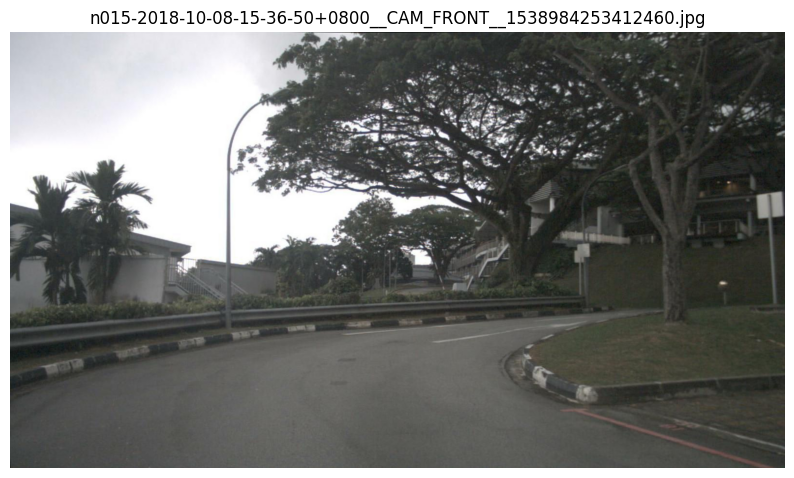

In [1]:
import os
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from nuscenes.nuscenes import NuScenes

# === Configuración ===
dataroot = r"C:/Users/usuario/Desktop/CAF/v1.0-mini_canbus-001"
fps      = 10              # Ajusta el framerate deseado
delay    = 1.0 / fps

# === Inicializar NuScenes ===
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=False)

# === Buscar la escena por nombre ===
scene_name = "scene-0916"
scene = next((s for s in nusc.scene if s['name'] == scene_name), None)
if scene is None:
    raise ValueError(f"No se encontró la escena '{scene_name}' en el dataset.")

# === Recorrer todos los samples de CAM_FRONT en esa escena ===
sample_token = scene['first_sample_token']
cam_front_files = []

while sample_token:
    sample = nusc.get('sample', sample_token)
    cam_token = sample['data']['CAM_FRONT']
    cam_data  = nusc.get('sample_data', cam_token)
    # Construir ruta absoluta al archivo de imagen
    cam_front_files.append(os.path.join(dataroot, cam_data['filename']))
    sample_token = sample['next']  # será None al llegar al final

# === Renderizar en el notebook ===
for img_path in cam_front_files:
    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] No se pudo cargar {img_path}")
        continue

    # Convertir BGR → RGB para matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    display(plt.gcf())
    plt.close()

    time.sleep(delay)
    clear_output(wait=True)


In [ ]:
'''Vemos que es curva hacia la derecha, luego sigue recto un tramo corto y da otra curva hacia la derecha otra
vez. Posteriormente recto y luego curva hacia la izquierda'''

In [ ]:
'''Ahora vamos a hacer el render con el YAW calculado a partir de la velocidad angular'''

In [13]:
# === Parámetros ===
DATASET_PATH = "C:/Users/usuario/Desktop/CAF/v1.0-mini_canbus-001/"
SAVE_IMG_DIR = "C:/Users/usuario/Desktop/CAF/Render_LIDAR/velo_angular_yaw/"
VIDEO_PATH = os.path.join(SAVE_IMG_DIR, "render_yaw.mp4")
CSV_PATH = "C:/Users/usuario/Desktop/CAF/df_0916.csv"
FOV_deg = 60
FOV_rad = np.radians(FOV_deg)
half_fov = FOV_rad / 2
FPS = 3

# === Crear directorio si no existe ===
os.makedirs(SAVE_IMG_DIR, exist_ok=True)

# === Cargar nuScenes y el CSV con yaw ===
nusc = NuScenes(version='v1.0-mini', dataroot=DATASET_PATH, verbose=True)
df_0916 = pd.read_csv(CSV_PATH, parse_dates=['timestamp_dt'])
df_0916['yaw_v_w'] = df_0916['yaw_v_w'].fillna(0)
yaw_dict = dict(zip(df_0916['timestamp_dt'], df_0916['yaw_v_w']))

# === Parámetros de render ===
W, H = 800, 800
SCALE = 6  # Zoom
ORIGIN_Y_PERCENTAGE = 0.05  # Cuanto más alto, más abajo queda el coche
ORIGIN = (W // 2, int(H * ORIGIN_Y_PERCENTAGE))

def lidar_to_image(points, yaw_deg, fov_rad):
    img = np.zeros((H, W, 3), dtype=np.uint8)
    x = -points[0]
    y = points[1]
    px = (x * SCALE + ORIGIN[0]).astype(int)
    py = (H - (y * SCALE + ORIGIN[1])).astype(int)

    valid = (px >= 0) & (px < W) & (py >= 0) & (py < H)
    img[py[valid], px[valid]] = (0, 255, 0)

    # Dibujar flecha del yaw
    yaw_rad = np.radians(yaw_deg)
    arrow_length = 100  # Longitud de la flecha
    x0, y0 = (W // 2, int(H * (1-ORIGIN_Y_PERCENTAGE)))

    x1 = int(x0 - arrow_length * np.sin(yaw_rad))
    y1 = int(y0 - arrow_length * np.cos(yaw_rad))
    cv2.arrowedLine(img, (x0, y0), (x1, y1), (255, 0, 255), 2, tipLength=0.1)

    # Dibujar líneas de FOV
    for angle in [-fov_rad/2, fov_rad/2]:
        angle_abs = yaw_rad + angle
        x2 = int(x0 - 200 * np.sin(angle_abs))
        y2 = int(y0 - 200 * np.cos(angle_abs))
        cv2.line(img, (x0, y0), (x2, y2), (255, 0, 255), 1)

    # Texto de yaw
    cv2.putText(img, f"Yaw: {yaw_deg:.1f} Degrees", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    return img

# === Buscar escena 0916 ===
scene = [s for s in nusc.scene if 'scene-0916' in s['name']][0]
sample_token = scene['first_sample_token']

frames = []
i = 0
while sample_token:
    sample = nusc.get('sample', sample_token)
    lidar_token = sample['data']['LIDAR_TOP']
    lidar_data = nusc.get('sample_data', lidar_token)
    lidar_path = os.path.join(nusc.dataroot, lidar_data['filename'])

    # Timestamp con zona horaria
    timestamp = datetime.utcfromtimestamp(lidar_data['timestamp'] / 1e6).replace(tzinfo=timezone.utc)
    closest = min(yaw_dict.keys(), key=lambda d: abs(d - timestamp))
    yaw_deg = yaw_dict[closest]
    yaw_rad = np.radians(yaw_deg)

    # Cargar y filtrar LIDAR
    pc = LidarPointCloud.from_file(lidar_path)
    points = pc.points
    angles = np.arctan2(points[0], points[1])
    angle_diff = (angles - yaw_rad + np.pi) % (2 * np.pi) - np.pi
    mask = np.abs(angle_diff) <= half_fov
    filtered_points = points[:, mask]

    # Renderizar y guardar imagen
    img = lidar_to_image(filtered_points, yaw_deg, FOV_rad)
    frame_path = os.path.join(SAVE_IMG_DIR, f"frame_{i:04d}.png")
    cv2.imwrite(frame_path, img)
    frames.append(img)

    print(f"Frame {i+1}: Yaw={yaw_deg:.1f}°, Puntos={filtered_points.shape[1]}")
    sample_token = sample['next']
    i += 1

# === Crear video MP4 ===
if frames:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(VIDEO_PATH, fourcc, FPS, (W, H))
    for frame in frames:
        out.write(frame)
    out.release()
    print(f"\n✅ Video guardado en: {VIDEO_PATH}")
else:
    print("No se generaron frames.")


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.731 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.
Frame 1: Yaw=-31.1°, Puntos=5388
Frame 2: Yaw=-30.4°, Puntos=5343
Frame 3: Yaw=-30.5°, Puntos=5302
Frame 4: Yaw=-28.8°, Puntos=5246
Frame 5: Yaw=-23.8°, Puntos=5085
Frame 6: Yaw=-19.0°, Puntos=4976
Frame 7: Yaw=-11.6°, Puntos=4921
Frame 8: Yaw=0.0°, Puntos=4959
Frame 9: Yaw=0.0°, Puntos=4981
Frame 10: Yaw=0.0°, Puntos=4987
Frame 11: Yaw=0.0°, Puntos=4910
Frame 12: Yaw=0.0°, Puntos=4915
Frame 13: Yaw=0.0°, Puntos=4918
Frame 14: Yaw=-20.7°, Puntos=4829
Frame 15: Yaw=-29.6°, Puntos=5013
Frame 16: Yaw=-33.4°, Puntos=5026
Frame 17: Yaw=-38.1°, Puntos=5031
Frame 18: Yaw=-43.9°, Puntos=4994
Frame 19: Yaw=-39.7°, Puntos=4851
Frame 20: Yaw=-27.1°, Puntos=4788
Frame 21: Yaw=-9.6

In [ ]:
'''COMPARACIÓN DE AMBOS MÉTODOS DE YAW'''

In [16]:
from moviepy.editor import VideoFileClip, CompositeVideoClip
import os

# Rutas a tus vídeos
path1 = "C:/Users/usuario/Desktop/CAF/Render_LIDAR/velo_angular_yaw/render_yaw.mp4"
path2 = "C:/Users/usuario/Desktop/CAF/Render_LIDAR/centripetal_yaw/render_yaw.mp4"

# Carga
clip1 = VideoFileClip(path1)
clip2 = VideoFileClip(path2).set_opacity(0.5)  # 50% de transparencia

# Asegurarnos de que tienen el mismo tamaño
clip2 = clip2.resize(clip1.size)

# Superponer clip2 sobre clip1
final = CompositeVideoClip(
    [clip1, clip2.set_position(("center", "center"))],
    size=clip1.size
)

# Ruta de salida
output_path = "C:/Users/usuario/Desktop/CAF/Render_LIDAR/combined_overlay.mp4"

# Guardar con el mismo FPS que clip1
final.write_videofile(output_path, fps=clip1.fps)


Moviepy - Building video C:/Users/usuario/Desktop/CAF/Render_LIDAR/combined_overlay.mp4.
Moviepy - Writing video C:/Users/usuario/Desktop/CAF/Render_LIDAR/combined_overlay.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/usuario/Desktop/CAF/Render_LIDAR/combined_overlay.mp4


In [ ]:
'''Se puede apreciar diferencias en la orientación dependiendo de como calculemos el YAW, por lo que procederemos
a hacer un análisis de si efectivamente la diferencia es significativa o no.'''

In [27]:
from scipy.signal import butter, filtfilt

# === FILTRO BUTTERWORTH 2 Hz ===
fs = 100       # Frecuencia de muestreo (Hz)
order = 4
cutoff = 2.0
b, a = butter(order, cutoff / (0.5 * fs), btype='low')

In [37]:
import os
import re
import json
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.signal import filtfilt  # usa tus b, a ya definidos en el entorno

# --- Ruta donde están tus JSON de CAN-bus ---
dir_CANbus = r'C:/Users/usuario/Desktop/CAF/v1.0-mini_canbus-001/v1.0-mini/can_bus/can_bus'

def procesar_escena(ruta):
    registros = []
    with open(ruta, 'r') as f:
        contenido = json.load(f)
    for r in contenido:
        if 'accel' in r and 'vel' in r and 'utime' in r:
            registros.append({
                'timestamp_dt': datetime.utcfromtimestamp(r['utime'] / 1e6).replace(tzinfo=None),
                'accel_cent':   r['accel'][1],
                'vel_x':        r['vel'][0],
                'rotation_rate_z': r.get('rotation_rate',[None,None,None])[2]
            })
    if not registros:
        return pd.DataFrame(columns=[
            'timestamp_dt','accel_cent','vel_x','rotation_rate_z',
            'accel_cent_filt','rotation_rate_z_filt'
        ])
    df = pd.DataFrame(registros)
    df.sort_values('timestamp_dt', inplace=True)
    df.reset_index(drop=True, inplace=True)
    # aplica tu filtro Butterworth con b, a definidos en el entorno
    df['accel_cent_filt']      = filtfilt(b, a, df['accel_cent'])
    df['rotation_rate_z_filt'] = filtfilt(b, a, df['rotation_rate_z'])
    return df

def calcular_radio_por_aceleracion(df):
    df['radio_R'] = df.apply(
        lambda row: row['vel_x']**2 / row['accel_cent_filt']
        if abs(row['accel_cent_filt']) >= 0.75 else np.nan,
        axis=1
    )
    return df

def calcular_radio_por_rot_rate(df):
    df['radio_R_rot'] = df.apply(
        lambda row: row['vel_x'] / row['rotation_rate_z_filt']
        if (
            pd.notna(row['rotation_rate_z_filt']) and
            abs(row['rotation_rate_z_filt']) > 1e-2 and
            abs(row['accel_cent_filt']) >= 0.75
        )
        else np.nan,
        axis=1
    )
    return df

# Parámetros geométricos para el cálculo de yaw
delta_y = 0
delta_R = 0
delta_x = 2.0
L       = 10

def calcular_yaw_con_radio(df, radio_col):
    yaw_list = []
    for R in df.get(radio_col, []):
        if pd.isna(R) or abs(R) < 1e-3:
            yaw_list.append(np.nan)
        else:
            phi      = L / abs(R)
            delta_yR = delta_R * np.cos(phi)
            delta_xR = delta_R * np.sin(phi)
            num      = abs(R) - abs(R)*np.cos(phi) + delta_yR
            den      = abs(R)*np.sin(phi) - delta_x + delta_xR
            yaw      = np.arctan2(num, den)
            if R < 0:
                yaw *= -1
            yaw_list.append(np.degrees(yaw))
    return yaw_list

# expresión regular para ficheros *_pose.json
pattern = re.compile(r'scene-(\d+)_pose\.json$')
pose_files = []
for fname in os.listdir(dir_CANbus):
    m = pattern.match(fname)
    if m:
        pose_files.append((int(m.group(1)), fname))
pose_files.sort(key=lambda x: x[0])

# limitar a las primeras 50
pose_files = pose_files[:50]

# acumulador de DataFrames
all_dfs = []

for scene_num, fname in pose_files:
    scene_id = f"scene-{scene_num:04d}"
    path     = os.path.join(dir_CANbus, fname)
    print(f"Procesando {scene_id}…")

    df_scene = procesar_escena(path)
    if df_scene.empty:
        print(f"  ⚠️ {scene_id} no tiene datos útiles, omitido.")
        continue

    # calcula radios
    df_scene = calcular_radio_por_aceleracion(df_scene)
    df_scene = calcular_radio_por_rot_rate(df_scene)

    # calcula yaws
    df_scene['yaw_v2_a'] = calcular_yaw_con_radio(df_scene, 'radio_R')
    df_scene['yaw_v_w']  = calcular_yaw_con_radio(df_scene, 'radio_R_rot')

    # añade columna de escena
    df_scene['scene_id'] = scene_id

    # selecciona solo campos deseados
    out = df_scene[['scene_id','timestamp_dt','yaw_v2_a','yaw_v_w']]
    all_dfs.append(out)

# concatena y guarda en un único CSV
if all_dfs:
    df_complete = pd.concat(all_dfs, ignore_index=True)
    output_path = os.path.join(os.path.dirname(dir_CANbus), 'all_scenes_yaws.csv')
    df_complete.to_csv(output_path, index=False)
    print(f"\n✅ Guardado CSV con todos los yaws en: {output_path}")
else:
    print("⚠️ No se generaron datos para ninguna escena.")


Procesando scene-0001…
Procesando scene-0002…
Procesando scene-0003…
Procesando scene-0004…
Procesando scene-0005…
Procesando scene-0006…
Procesando scene-0007…
Procesando scene-0008…
Procesando scene-0009…
Procesando scene-0010…
Procesando scene-0011…
Procesando scene-0012…
Procesando scene-0013…
Procesando scene-0014…
Procesando scene-0015…
Procesando scene-0016…
Procesando scene-0017…
Procesando scene-0018…
Procesando scene-0019…
Procesando scene-0020…
Procesando scene-0021…
Procesando scene-0022…
Procesando scene-0023…
Procesando scene-0024…
Procesando scene-0025…
Procesando scene-0026…
Procesando scene-0027…
Procesando scene-0028…
Procesando scene-0029…
Procesando scene-0030…
Procesando scene-0031…
Procesando scene-0032…
Procesando scene-0033…
Procesando scene-0034…
Procesando scene-0035…
Procesando scene-0036…
Procesando scene-0038…
Procesando scene-0039…
Procesando scene-0041…
Procesando scene-0042…
Procesando scene-0043…
Procesando scene-0044…
Procesando scene-0045…
Procesando 

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, t
from math import sqrt

# 1) Ruta a tu CSV consolidado de yaws
csv_path = r"C:\Users\usuario\Desktop\CAF\all_scenes_yaws.csv"

# 2) Cargar y filtrar
df = pd.read_csv(csv_path, parse_dates=['timestamp_dt'])
df_clean = df[['yaw_v2_a','yaw_v_w']].dropna()

# 3) Eliminar registros con |yaw| < 5° en ambos métodos
mask = (df_clean['yaw_v2_a'].abs() >= 5) | (df_clean['yaw_v_w'].abs() >= 5)
df_f = df_clean[mask]

# 4) Trabajar con valores absolutos
abs_df = df_f.abs()
n = len(abs_df)

print(f"Número de pares considerados: {n}\n")

# 5) Descriptivos
print("Descriptivos de |yaw|:")
print(abs_df.describe()[['yaw_v2_a','yaw_v_w']], "\n")

# 6) t-test pareado
t_stat, p_val = ttest_rel(abs_df['yaw_v2_a'], abs_df['yaw_v_w'])
print(f"t-test pareado: t = {t_stat:.4f}, p = {p_val:.4e}")

# 7) Cohen's d (paired)
diff = abs_df['yaw_v2_a'] - abs_df['yaw_v_w']
mean_diff = diff.mean()
std_diff = diff.std(ddof=1)
cohen_d = mean_diff / std_diff
print(f"Cohen’s d: {cohen_d:.4f}")

# 8) IC 95% de la diferencia media
se = std_diff / sqrt(n)
dfree = n - 1
t_crit = t.ppf(0.975, dfree)
ci_lo = mean_diff - t_crit * se
ci_hi = mean_diff + t_crit * se
print(f"IC 95% diff media: [{ci_lo:.4f}, {ci_hi:.4f}]\n")

# 9) TOST de equivalencia 
#    H0: |μ₁−μ₂| ≥ delta  vs  H1: |μ₁−μ₂| < delta
delta = 1.0  # Smallest Effect of Interest (1 grado)
# Test lower bound: μdiff > −delta  =>  t1 = (mean_diff - (−delta)) / se
t1 = (mean_diff + delta) / se
p1 = 1 - t.cdf(t1, dfree)           # one-sided p
# Test upper bound: μdiff < +delta =>  t2 = (mean_diff - delta) / se
t2 = (mean_diff - delta) / se
p2 = t.cdf(t2, dfree)               # one-sided p

print(f"TOST equivalencia (±{delta}°):")
print(f"  t_lower = {t1:.4f}, p_lower = {p1:.4e}")
print(f"  t_upper = {t2:.4f}, p_upper = {p2:.4e}")

if (p1 < 0.05) and (p2 < 0.05):
    print("  ⇒ Se rechaza H₀ de diferencia ≥ ±1°: ¡Equivalencia demostrada!")
else:
    print("  ⇒ No se demuestra equivalencia en ±1°.\n")

# 10) Interpretación final
print("Interpretación resumida:")
print(f" - p-value t-test: {p_val:.2e}  (con gran n suele ser siempre <0.05)")
print(f" - Cohen’s d: {cohen_d:.3f}  ({'muy pequeño' if abs(cohen_d)<0.2 else 'pequeño/moderado/grande'})")
print(f" - IC 95% diff: [{ci_lo:.2f}, {ci_hi:.2f}] grados")
print(f" - Equivalencia ±{delta}°: {'SÍ' if (p1<0.05 and p2<0.05) else 'NO'}")


Número de pares considerados: 4968

Descriptivos de |yaw|:
          yaw_v2_a      yaw_v_w
count  4968.000000  4968.000000
mean     24.240450    21.623923
std      18.351120    14.724860
min       3.746308     1.410950
25%      11.519924    10.067613
50%      19.648765    19.815996
75%      29.583465    30.508806
max      90.834207    71.861774 

t-test pareado: t = 24.8874, p = 6.0481e-129
Cohen’s d: 0.3531
IC 95% diff media: [2.4104, 2.8226]

TOST equivalencia (±1.0°):
  t_lower = 34.3990, p_lower = 0.0000e+00
  t_upper = 15.3758, p_upper = 1.0000e+00
  ⇒ No se demuestra equivalencia en ±1°.

Interpretación resumida:
 - p-value t-test: 6.05e-129  (con gran n suele ser siempre <0.05)
 - Cohen’s d: 0.353  (pequeño/moderado/grande)
 - IC 95% diff: [2.41, 2.82] grados
 - Equivalencia ±1.0°: NO


In [ ]:
'''Vemos que en el caso del YAW calculado a partir de la aceleración centrípeta, el valor medio absoluto del YAW
es mayor, lo que se traduce a que si usamos los datos del acelerómetro, estaríamos mirando más hacia el centro
de la curva que si usamos los datos de la velocidad angular.'''